# **TikTok Project**

Build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

# **Classify videos using machine learning**

**Modeling workflow and model selection process**

There are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)




### **Task 1: Imports and data loading**

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

### **Task 2: Examine data, summary info, and descriptive stats**

In [3]:
# Display first few rows
data.head(5)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# Get data types of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [5]:
# Get basic information
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [6]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [7]:
# Drop rows with missing values
data = data.dropna(axis=0)
data.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [8]:
# Check for duplicates
data.duplicated().sum()

0

In [9]:
# Check class balance
data['claim_status'].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

### **Task 3: Feature engineering**

In [10]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [11]:
# Calculate the average text_length for claims and opinions
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


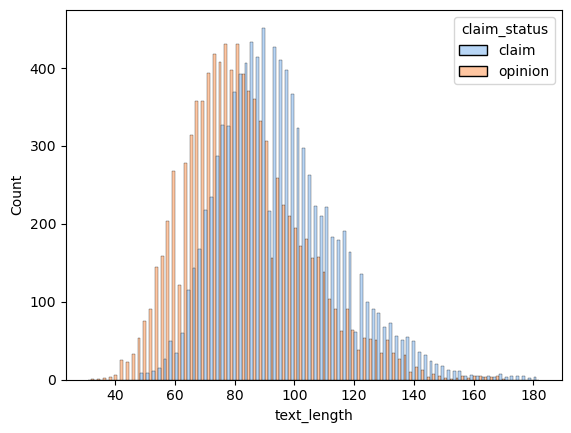

In [12]:
# Visualize the distribution of `text_length` for claims and opinions
sns.histplot(data=data, stat='count', multiple='dodge', x='text_length', kde=False, palette='pastel',hue='claim_status', element='bars', legend=True)
plt.show()

In [13]:
# Encode target and catgorical variables
# Select outcome variable
X = data.copy()
X = X.drop(['#', 'video_id', 'video_transcription_text'], axis=1)
X['claim_status'] = X['claim_status'].replace({'opinion':0, 'claim':1})
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)
X

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
19079,0,49,6067.0,423.0,81.0,8.0,2.0,65,0,0,0
19080,0,23,2973.0,820.0,70.0,3.0,0.0,66,0,0,0
19081,0,50,734.0,102.0,7.0,2.0,1.0,53,0,0,0
19082,0,8,3394.0,655.0,123.0,11.0,4.0,80,0,0,0


### **Task 4: Split the data**


In [14]:
# Isolate target variable
y = X['claim_status']
y

0        1
1        1
2        1
3        1
4        1
        ..
19079    0
19080    0
19081    0
19082    0
19083    0
Name: claim_status, Length: 19084, dtype: int64

In [15]:
# Isolate features
X = X.drop(['claim_status'], axis=1)
X.head(5)


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


### **Task 5: Create train/validate/test sets**

In [16]:
# Split data into training and testing sets, 80/20
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [18]:
# Confirm that the dimensions of the training, validation, and testing sets are in alignment
X_train.shape, X_val.shape, X_test.shape

((11450, 10), (3817, 10), (3817, 10))

### **Task 6: Build models**
Build a random forest model

In [19]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)
# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth':[5,7,None],
            'max_features':[0.3,0.6],
            'max_samples':[0.7],
            'min_samples_leaf':[1,2],
            'min_samples_split':[2,3],
            'n_estimators':[75,100,200]}

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}
# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [20]:
# Examine best recall score
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='f1', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [21]:
# Examine best recall score
rf_cv.best_score_

0.9951433900450615

In [22]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

### **Task 7: Evaluate model**

Evaluate models against validation criteria

In [23]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val)

In [24]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [25]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

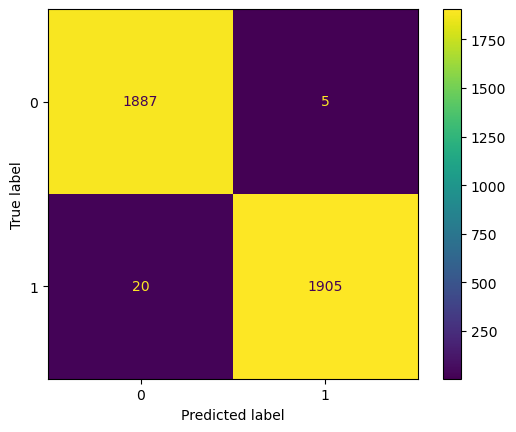

In [26]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

log_disp.plot()
plt.show()

Notes:

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [27]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



### **Use champion model to predict on test data**

In [28]:
y_pred = rf_cv.best_estimator_.predict(X_test)

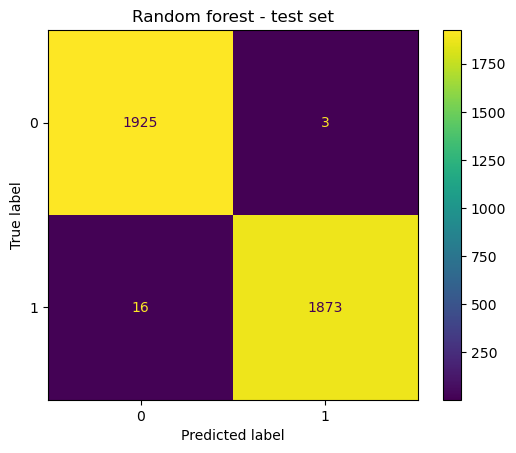

In [29]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

log_disp.plot()
plt.title('Random forest - test set');
plt.show()

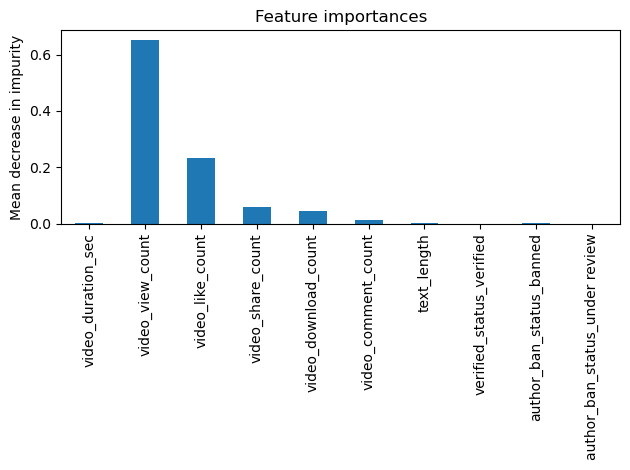

In [30]:
# Feature importances of champion model
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

Notes:

Each feature's importance is represented as a number, where higher numbers indicate more important features. These importance values are calculated based on how much each feature decreases the weighted impurity in a tree.

### **Task 8: Conclusion**

**Summary**:
The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

**Would you recommend using this model? Why or why not?**
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F1 scores were consistently high. The model very successfully classified claims and opinions.

**What was your model doing? Can you explain how it was making predictions?**
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.